In [ ]:
# 下載並解壓縮訓練資料
!gdown --id '19CzXudqN58R3D-1G8KeFWk8UDQwlb8is' --output food-11.zip
!unzip food-11.zip

In [ ]:
# 下載 pretrained model
!gdown --id '1CShZHsO8oAZwxQkMe7jRtEgSNb2w_OZu' --output checkpoint.pth

Downloading...
From: https://drive.google.com/uc?id=1CShZHsO8oAZwxQkMe7jRtEgSNb2w_OZu
To: /content/checkpoint.pth
170MB [00:01, 98.7MB/s]


In [ ]:
# 安裝lime
!pip install lime==0.1.1.37

     |████████████████████████████████| 275 kB 5.2 MB/s 
  Created wheel for lime: filename=lime-0.1.1.37-py3-none-any.whl size=284290 sha256=efcf16999c2156b92567ebc51bc291f9214787a423090407ae780a836b8b7b4d
  Stored in directory: /root/.cache/pip/wheels/5d/7a/8d/30e0ea15164fb80d5484e83ab991e188d6a9d8febfada307a6
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12082 sha256=9aaaa132d77404cc731b9b5078624b90c1624960a75cbd5d0f8a356b6eb236f2
  Stored in directory: /root/.cache/pip/wheels/f0/fd/1f/3e35ed57e94cd8ced38dd46771f1f0f94f65fec548659ed855
Successfully built lime progressbar


In [ ]:
import os
import sys
import argparse
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from skimage.segmentation import slic
from lime import lime_image
from pdb import set_trace #剛好沒用到

In [ ]:
args = {
      'ckptpath': './checkpoint.pth',
      'dataset_dir': './food-11/'
}
args = argparse.Namespace(**args)
args

Namespace(ckptpath='./checkpoint.pth', dataset_dir='./food-11/')

## Dataset

剛好把transforms.Compose一起寫進dataset中


In [ ]:
# 要從在taining資料夾中的圖片檔名抓出label
# train data path and label
def get_paths_labels(train_path):  
  train_path_ = os.listdir(train_path)
  train_path_.sort()
  train_paths = [f'{train_path}/{i}' for i in train_path_]
  train_labels = [int(i.split('_')[0]) for i in train_path_]
  return train_paths, train_labels

train_paths, train_labels = get_paths_labels('./food-11/training')

In [ ]:
# 由於之前訓練都把圖改成128*128所以這次直接設定在dataset裏頭
# 之前用cv2.resize(img,(128,128))

# 目的是給序號就給圖片跟所屬標籤，一開始建立這個dataset則使用全部的圖片路徑跟上面整理出來的label
class FoodDataset(Dataset):
  def __init__(self, paths, labels, mode):

    # 匯入上面整理的全部路徑跟標籤 (list)
    self.paths = paths
    self.labels = labels

    # 定義eval | train模式來決定用哪種transforms
    # 訓練時可以翻轉
    trainTransform = transforms.Compose([
            transforms.Resize(size=(128, 128)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
        ])
    
    # 計算時不用
    evalTransform = transforms.Compose([
        transforms.Resize(size=(128, 128)),
        transforms.ToTensor(),
    ])

    self.transform = trainTransform if mode == 'train' else evalTransform

    # Dataset格式必備的兩個
  def __len__(self):
      return len(self.paths) #所有路徑的數量 == 圖片數量

  def __getitem__(self, index):
      X = Image.open(self.paths[index])
      X = self.transform(X)
      Y = self.labels[index]
      return X, Y

  # 為了拉圖片出來用的方便起見，就不把dataset丟進 dataloader，直接在這建一樣的功能
  def getbatch(self, indices): #假設indices是list，裏頭都是圖片序號(就可以抓上面的getitem)
    images = []
    labels = []
    for index in indices:
      image, label = self.__getitem__(index)
      images.append(image)
      labels.append(label)
    return torch.stack(images), torch.tensor(labels)

# 設定後面要用的資料來源
train_set = FoodDataset(train_paths, train_labels, mode='eval')

## 定義模型物件 & 匯入pre-trained model 參數

In [ ]:
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()

    def building_block(indim, outdim):
      return [
        nn.Conv2d(indim, outdim, 3, 1, 1),
        nn.BatchNorm2d(outdim),
        nn.GeLU(),
      ]
    def stack_blocks(indim, outdim, block_num):
      layers = building_block(indim, outdim)
      for i in range(block_num - 1):
        layers += building_block(outdim, outdim)
      layers.append(nn.MaxPool2d(2, 2, 0))
      return layers

    cnn_list = []
    cnn_list += stack_blocks(3, 128, 3)
    cnn_list += stack_blocks(128, 128, 3)
    cnn_list += stack_blocks(128, 256, 3)
    cnn_list += stack_blocks(256, 512, 1)
    cnn_list += stack_blocks(512, 512, 1)
    self.cnn = nn.Sequential( * cnn_list)

    dnn_list = [
      nn.Linear(512 * 4 * 4, 1024),
      nn.ReLU(),
      nn.Dropout(p = 0.3),
      nn.Linear(1024, 11),
    ]
    self.fc = nn.Sequential( * dnn_list)

  def forward(self, x):
    out = self.cnn(x)
    out = out.reshape(out.size()[0], -1)
    return self.fc(out)

In [ ]:
model = Classifier().cuda()
checkpoint = torch.load(args.ckptpath)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

# 打印出梯度判斷輸入資料

In [ ]:
def normalize(image):
  return (image - image.min()) / (image.max() - image.min())

def compute_saliency_maps(x, y, model):
  model.eval()
  x = x.cuda()

  # 最關鍵的一行 code
  # 因為我們要計算 loss 對 input image 的微分，原本 input x 只是一個 tensor，預設不需要 gradient
  # 這邊我們明確的告知 pytorch 這個 input x 需要gradient，這樣我們執行 backward 後 x.grad 才會有微分的值
  x.requires_grad_()  # 沒開的話 x.grad == None type 
  
  y_pred = model(x)
  loss_func = torch.nn.CrossEntropyLoss()
  loss = loss_func(y_pred, y.cuda())
  loss.backward()

  
  # 再來解釋這個為什麼可以辦到
  # 把當下的gradient取絕對值後分離下來
  saliencies = x.grad.abs().detach().cpu() # 覺得是用lossbackward的梯度，這邊是依據loss，在讓數值更準確的方向上
  # saliencies: (batches, channels, height, weight)
  # 因為接下來我們要對每張圖片畫 saliency map，每張圖片的 gradient scale 很可能有巨大落差
  # 可能第一張圖片的 gradient 在 100 ~ 1000，但第二張圖片的 gradient 在 0.001 ~ 0.0001
  # 如果我們用同樣的色階去畫每一張 saliency 的話，第一張可能就全部都很亮，第二張就全部都很暗，
  # 如此就看不到有意義的結果，我們想看的是「單一張 saliency 內部的大小關係」，
  # 所以這邊我們要對每張 saliency 各自做 normalize。手法有很多種，這邊只採用最簡單的
  saliencies = torch.stack([normalize(item) for item in saliencies])
  return saliencies

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


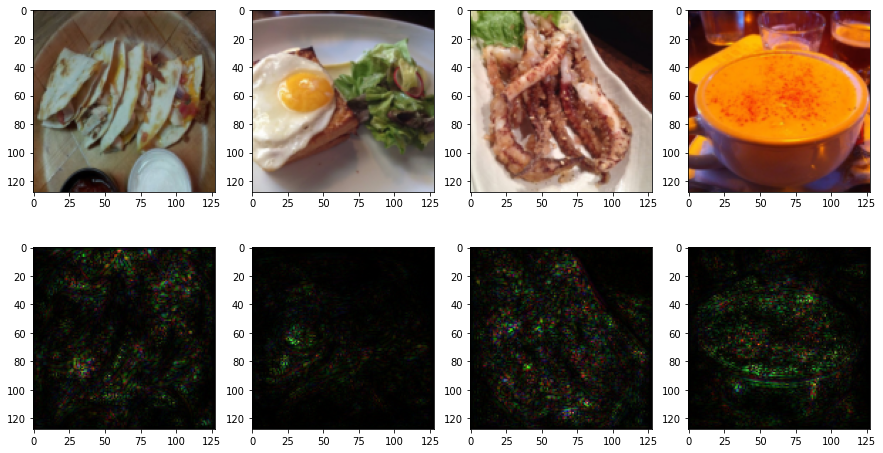

In [ ]:
# 指定想要一起 visualize 的圖片 indices
img_indices = [83, 4218, 4707, 8598]    #這邊數字只是隨便挑幾張圖出來用而已
images, labels = train_set.getbatch(img_indices) 
# images.shape torch.Size([4, 3, 128, 128]); labels.shape torch.Size([4]) # 4是這次要用的圖片數量
saliencies = compute_saliency_maps(images, labels, model)
# saliencies torch.Size([4, 3, 128, 128])
# 使用 matplotlib 畫出來
fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))
for row, target in enumerate([images, saliencies]):
  for column, img in enumerate(target):
    axs[row][column].imshow(img.permute(1, 2, 0).numpy())
    # 小知識：permute 是什麼，為什麼這邊要用?
    # 在 pytorch 的世界，image tensor 各 dimension 的意義通常為 (channels, height, width)
    # 但在 matplolib 的世界，想要把一個 tensor 畫出來，形狀必須為 (height, width, channels)
    # 因此 permute 是一個 pytorch 很方便的工具來做 dimension 間的轉換
    # 這邊 img.permute(1, 2, 0)，代表轉換後的 tensor，其
    # - 第 0 個 dimension 為原本 img 的第 1 個 dimension，也就是 height
    # - 第 1 個 dimension 為原本 img 的第 2 個 dimension，也就是 width
    # - 第 2 個 dimension 為原本 img 的第 0 個 dimension，也就是 channels

plt.show()
plt.close()

## 隨便拉一個圖片出來測試

In [ ]:
img_indices = [84, 4218, 4707, 8598]
images, labels = train_set.getbatch(img_indices)

In [ ]:
labels

tensor([0, 3, 4, 9])

torch.Size([3, 128, 128])


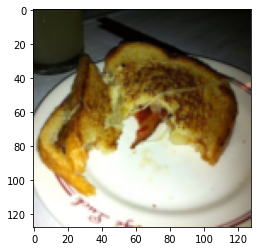

In [ ]:
print(images[0].shape)
plt.imshow(
    images[0].permute(1, 2,0).numpy()
    )

In [ ]:
saliencies = compute_saliency_maps(images, labels, model)

torch.Size([3, 128, 128])


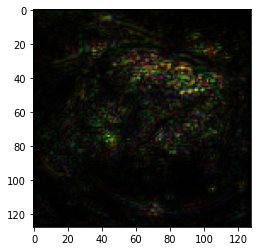

In [ ]:
sal = saliencies[0]
print(sal.shape)
plt.imshow(
    sal.permute(1, 2,0).numpy()
    )

# HOOK

## 直接寫的版本

In [ ]:
# 這邊目標有兩個：
# 1. 某個filter他專門分析的圖像類型 
# 2. 該filter的activation map 看他分析時主要抓的的輪廓
# 兩者可以比較該輪廓是否偏線型

# 因為要調色，一樣要用標準化
def normalize(image):
  return (image - image.min()) / (image.max() - image.min())

layer_activations = None

def hook(model, input, output):
  global layer_activations
  layer_activations = output

model.eval()
cnnid = 15   # cnn中的第幾層
filterid = 0 # filter的id
iteration = 100 # 在修改數據找出filter最擅長處理的類型時，修改數據的次數
lr = 0.1

# img_indices = [83, 4218, 4707, 8598]
img_indices = [80, 4200, 4700, 8590]
images, labels = train_set.getbatch(img_indices)
x = images
# start hook------------------------------------------

# part1 filter_activations
# 找出他分析圖片時的抓取輪廓，使用已經train的model，這邊紀錄的就是該模型現在訓練時的參數的gradient
hook_handle = model.cnn[cnnid].register_forward_hook(hook)
# register_forward_hook這個套件本身會output 三個東西，剛好用hook來接並存起來
# 該套件於目前四種類型的層都可以用
# layer_activations.shape [X, 128, 64, 64]  X的維度是看放幾張圖進來就有幾維

model(x.cuda())
# 執行model，並讓上一行建立的hook可以記錄所有filter狀況

filter_activations = layer_activations[:, filterid, :, :].detach().cpu()
# 所有要計算的圖片在filterid 的filter執行時的activation map 從 computational graph 截出來


# part2 filter_visualization
# 要找出可以最大程度 activate 該 filter 的圖片，所以不斷把圖片用偏微分以及ADAM修改最後輸出
x = x.cuda()
x.requires_grad_()

# 用optimizer修改數據
optimizer = Adam([x], lr=lr)

# 利用偏微分和 optimizer，逐步修改 input image 來讓 filter activation 越來越大
for iter in range(iteration):
  optimizer.zero_grad()
  model(x)

  objective = -layer_activations[:, filterid, :, :].sum()
  # 我們想知道的是，image 的微量變化會怎樣影響 activation 的程度
  # 因此 objective 是 filter activation 的加總，然後加負號代表我們想要做 maximization

  objective.backward()
  # 把filter activation的maximization偏微分
  optimizer.step()
  # 經由上面的傳遞要將filter activation最大化，由於激勵的目標是最大化activation，
  # 所以在把objective backward時，權重會被回傳的梯度所影響，進而影響x，
  # 但模型是eval所以在程式結束後不會因為這次事件而更改參數
filter_visualization = x.detach().cpu().squeeze()[0]
# 完成圖片修改，只剩下要畫出來，因此可以直接 detach 並轉成 cpu tensor


hook_handle.remove()
# end hook------------------------------------------

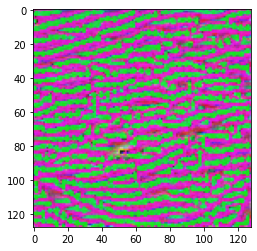

In [ ]:
# 畫出 filter visualization
plt.imshow(normalize(filter_visualization.permute(1, 2, 0)))
plt.show()
plt.close()

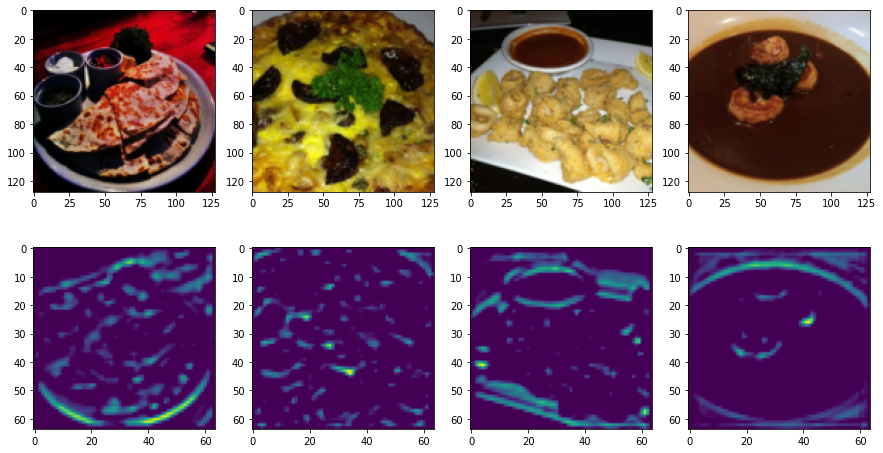

In [ ]:
# 畫出 filter activations
fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))
for i, img in enumerate(images):
  axs[0][i].imshow(img.permute(1, 2, 0))
for i, img in enumerate(filter_activations):
  axs[1][i].imshow(normalize(img))
plt.show()
plt.close()
# 從下面四張圖可以看到，activate 的區域對應到一些物品的邊界，尤其是顏色對比較深的邊界

## functional

In [ ]:
def normalize(image):
  return (image - image.min()) / (image.max() - image.min())


layer_activations = None
def hook(model, input, output):
  global layer_activations
  layer_activations = output


def filter_explaination(x,model,cnnid,filterid,iteration,lr):
  
  
  model.eval()
  

  # start hook------------------------------------------

  # part1 filter_activations
  hook_handle = model.cnn[cnnid].register_forward_hook(hook)
  # register_forward_hook這個套件本身會output 三個東西，剛好用hook來接並存起來
  # 該套件於目前四種類型的層都可以用
  # layer_activations.shape [X, 128, 64, 64]  X的維度是看放幾張圖近來就有幾維

  model(x.cuda())
  # 執行model，並讓上一行建立的hook可以記錄所有filter狀況

  filter_activations = layer_activations[:, filterid, :, :].detach().cpu()
  # 所有要計算的圖片在filterid 的filter執行時的activation map 從 computational graph 截出來


  # part2 filter_visualization
  # 要找出可以最大程度 activate 該 filter 的圖片，所以不斷把圖片用偏微分以及ADAM修改最後輸出
  x = x.cuda()
  x.requires_grad_()

  # 用optimizer修改數據
  optimizer = Adam([x], lr=lr)

  # 利用偏微分和 optimizer，逐步修改 input image 來讓 filter activation 越來越大
  for iter in range(iteration):
    optimizer.zero_grad()
    model(x)

    objective = -layer_activations[:, filterid, :, :].sum()
    # 我們想知道的是，image 的微量變化會怎樣影響 activation 的程度
    # 因此 objective 是 filter activation 的加總，然後加負號代表我們想要做 maximization

    objective.backward()
    # 把filter activation的maximization偏微分
    optimizer.step()
    # 經由上面的傳遞要將filter activation最大化
  filter_visualization = x.detach().cpu().squeeze()[0]
  # 完成圖片修改，只剩下要畫出來，因此可以直接 detach 並轉成 cpu tensor

  hook_handle.remove()
  # end hook------------------------------------------

  return filter_activations, filter_visualization

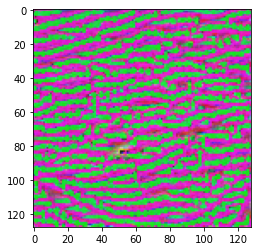

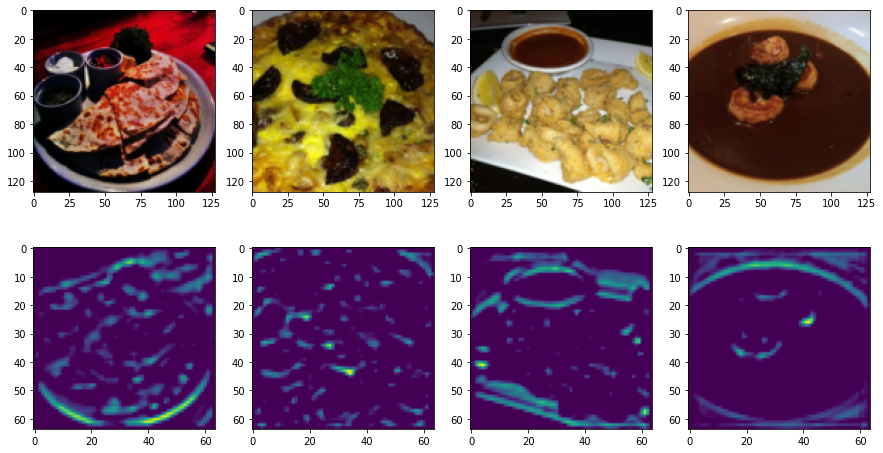

In [ ]:
# img_indices = [83, 4218, 4707, 8598]
img_indices = [80, 4200, 4700, 8590]
images, labels = train_set.getbatch(img_indices)
filter_activations, filter_visualization = filter_explaination(images, model, cnnid=15, filterid=0, iteration=100, lr=0.1)

# 畫出 filter visualization
plt.imshow(normalize(filter_visualization.permute(1, 2, 0)))
plt.show()
plt.close()
# 根據圖片中的線條，可以猜測第 15 層 cnn 其第 0 個 filter 可能在認一些線條、甚至是 object boundary
# 因此給 filter 看一堆對比強烈的線條，他會覺得有好多 boundary 可以 activate

# 畫出 filter activations
fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))
for i, img in enumerate(images):
  axs[0][i].imshow(img.permute(1, 2, 0))
for i, img in enumerate(filter_activations):
  axs[1][i].imshow(normalize(img))
plt.show()
plt.close()
# 從下面四張圖可以看到，activate 的區域對應到一些物品的邊界，尤其是顏色對比較深的邊界

# Lime

In [ ]:
def predict(input):
  # input: numpy array, (batches, height, width, channels)                                                                                                                                                     

  model.eval()                                                                                                                                                             
  input = torch.FloatTensor(input).permute(0, 3, 1, 2)                                                                                                            
  # 需要先將 input 轉成 pytorch tensor，且符合 pytorch 習慣的 dimension 定義
  # 也就是 (batches, channels, height, width)

  output = model(input.cuda())
  return output.detach().cpu().numpy()  #這邊要符合lime_image.LimeImageExplainer()的要求

# from skimage.segmentation import slic
def segmentation(input):
  # 利用 skimage 提供的 segmentation 將圖片分成 100 塊                                                                                                                                      
  return slic(input, n_segments=100, compactness=1, sigma=1) 

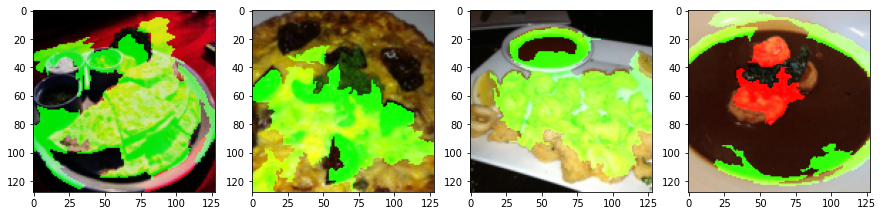

In [ ]:
img_indices = [80, 4200, 4700, 8590]
images, labels = train_set.getbatch(img_indices)
fig, axs = plt.subplots(1, len(img_indices), figsize=(15, 8))

np.random.seed(16)                                                                                                                                                       
# 讓實驗 reproducible
for idx, (image, label) in enumerate(zip(images.permute(0, 2, 3, 1).numpy(), labels)):                                                                                                                                             
    
    x = image.astype(np.double)
    # lime 這個套件要吃 numpy array

    explainer = lime_image.LimeImageExplainer()                                                                                                                              
    explaination = explainer.explain_instance(image=x, classifier_fn=predict, segmentation_fn=segmentation)
    # 基本上只要提供給 lime explainer 兩個關鍵的 function，事情就結束了
    # classifier_fn 定義圖片如何經過 model 得到 prediction
    # segmentation_fn 定義如何把圖片做 segmentation
    # doc: https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=explain_instance#lime.lime_image.LimeImageExplainer.explain_instance

    lime_img, mask = explaination.get_image_and_mask(                                                                                                                         
                                label=label.item(),                                                                                                                           
                                positive_only=False,                                                                                                                         
                                hide_rest=False,                                                                                                                             
                                num_features=11,                                                                                                                              
                                min_weight=0.05                                                                                                                              
                            )
    # 把 explainer 解釋的結果轉成圖片
    # doc: https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=get_image_and_mask#lime.lime_image.ImageExplanation.get_image_and_mask
    
    axs[idx].imshow(lime_img)

plt.show()
plt.close()

# 下圖結果中，綠色是單看該區域可以辨識出來的意思，反之則為紅色，第四張圖則主要辨識碗，
# 只看食物反而無法辨識，所以該類型食物如果照片不含碗，他有可能就會辨識錯


# Captum

In [ ]:
!pip install captum

     |████████████████████████████████| 1.4 MB 5.3 MB/s 


In [ ]:
import numpy as np

import torch
import torch.nn as nn

from captum.attr import IntegratedGradients

class ToyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(3, 3)
        self.relu = nn.ReLU()
        self.lin2 = nn.Linear(3, 2)

        # initialize weights and biases
        self.lin1.weight = nn.Parameter(torch.arange(-4.0, 5.0).view(3, 3))
        self.lin1.bias = nn.Parameter(torch.zeros(1,3))
        self.lin2.weight = nn.Parameter(torch.arange(-3.0, 3.0).view(2, 3))
        self.lin2.bias = nn.Parameter(torch.ones(1,2))

    def forward(self, input):
        return self.lin2(self.relu(self.lin1(input)))


model = ToyModel()
model.eval()

ToyModel(
  (lin1): Linear(in_features=3, out_features=3, bias=True)
  (relu): ReLU()
  (lin2): Linear(in_features=3, out_features=2, bias=True)
)

In [ ]:
# To make computations deterministic, let's fix random seeds:
torch.manual_seed(123)
np.random.seed(123)

In [ ]:
# Define input and baseline tensors:
input = torch.rand(2, 3)
baseline = torch.zeros(2, 3)

# Select algorithm to instantiate and apply (Integrated Gradients in this example):
ig = IntegratedGradients(model)
attributions, delta = ig.attribute(input, baseline, target=0, return_convergence_delta=True)
print('IG Attributions:', attributions)
print('Convergence Delta:', delta)

IG Attributions: tensor([[-0.5922, -1.5497, -1.0067],
        [ 0.0000, -0.2219, -5.1991]], dtype=torch.float64)
Convergence Delta: tensor([ 5.9605e-08, -8.8818e-16], dtype=torch.float64)


tensor([[0.2961, 0.5166, 0.2517],
        [0.6886, 0.0740, 0.8665]])


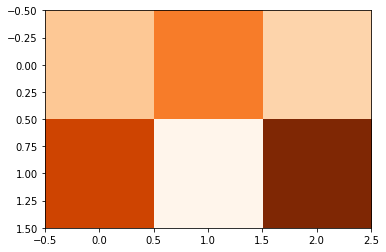

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(input,cmap='Oranges')
print(input)

tensor([[0., 0., 0.],
        [0., 0., 0.]])

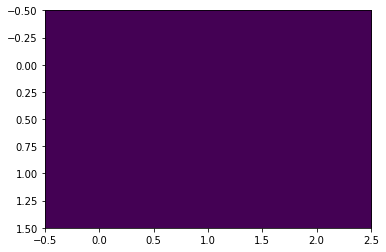

In [ ]:
plt.imshow(baseline)
baseline

tensor([[-0.5922, -1.5497, -1.0067],
        [ 0.0000, -0.2219, -5.1991]], dtype=torch.float64)

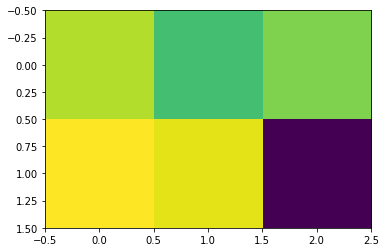

In [ ]:
plt.imshow(attributions)
attributions